In [ ]:
### PACKAGES FOR REINFORCEMENT LEARNING
import keras
from keras import layers, models, optimizers
from keras import backend as K
from collections import namedtuple, deque
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.optimizers import Adam

In [1]:
### PACKAGES/MODULES FOR DATA PROCESSING AND VISUALISATION
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
import datetime
import math
from numpy.random import choice
import random
from collections import deque


In [39]:
def read_real_data(name):
    path = '/Users/rubenexojo/Library/Mobile Documents/com~apple~CloudDocs/MSc Mathematical Finance - Manchester/dissertation/dissertation-codes/data/real-data/'
    return read_csv(path + name, index_col=0)

In [40]:
dataset = read_real_data('IBEX_25:07:2010_25:07:2021.csv')
dataset.shape

(2815, 6)

In [43]:
set_option('display.width', 100)
dataset.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-07-26,10476.700195,10512.400391,10331.000000,10506.700195,10506.689453,174600.0
2010-07-27,10544.799805,10684.700195,10533.099609,10645.000000,10644.989258,257400.0
2010-07-28,10712.400391,10721.799805,10595.900391,10643.900391,10643.889648,196600.0
2010-07-29,10678.000000,10788.000000,10602.500000,10659.500000,10659.489258,217400.0
2010-07-30,10607.799805,10638.599609,10430.299805,10499.799805,10499.789063,214600.0


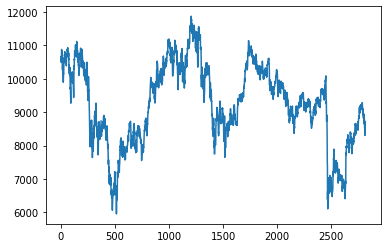

In [42]:
closing_prices  = dataset['Close'].tolist()
plt.plot(closing_prices)

In [44]:
print('Null Values =', dataset.isnull().values.any())

Null Values = True


In [47]:
for key in dataset.keys():
    dataset[key] = dataset[key].fillna(dataset[key].mean())

print('Null Values=', dataset.isnull().values.any())

Null Values= False


We have to partition our data set into the training set and the test set. The idea is to use the test set to confirm the good performance of our final model and understand if there is any overfitting. For example, we can use the 80\% of our data for modeling and 20\% for testing, as suggested by Tatsat et al. (2021).

In [49]:
X = list(dataset['Close'])
X = [float(x) for x in X]
validation_size = 0.2
train_size = int(len(X) * (1 - validation_size))

We are now ready to code our algorithm up, which in simple words just decides whether tu buy, sell or hold regarding the current market price.

The algorithm evaluates which action needs to be taken to optimise our strategy based on a $Q$-value. This $Q$-value determines the value of taking an action at a certain state, and also the value of the latter. To do so, we are going to use a deep $Q$-network which uses an ANN to approximate $Q$-values. Hence, the action value function should be defined as $Q_\theta(s,a)$m wgere $\theta$ is a vector of weights of a multilayered DQN that maps states to actions, which must be learnt in the process when approximating the $Q$-value function. 

We will need many modules and functions (see Tatsat et al, 2021):

1. Agent class. This holds the variables and member functions that perform the $Q$-learning.

2. Helper functions.

3. Training module. During traininng, the prescribed action for each day is predicted, the rewards are computed, and the deep learning-based $Q$-learning model weights are updated over a number of episodes. Additionally, the profit and loss of each action is summed to determine whether an overall profit has occurred. Aim: maximise the total profit.

In [52]:
class Agent:

    def __init__(self, state_size, is_eval = False, model_name = ""):
        self.state_size     = state_size # normalised previous days
        self.action_size    = 3 # hold, buy and sell
        self.memory         = deque(maxlen=1000)
        self.inventory      = []
        self.model_name     = model_name
        self.is_eval        = is_eval
    
        self.gamma          = 0.95
        self.epsilon        = 1.0
        self.epsilon_min    = 0.01
        self.epsilon_decay  = 0.995

        self.model = load_model("models/" + model_name) if is_eval \
            else self._model()
    
    def _model(self):
        model = Sequential()
        model.add(Dense(units=64, input_dim = self.state_size, activation = "relu"))
        model.add(Dense(units=32, activation="relu"))
        model.add(Dense(units=8, activation="relu"))
        model.add(Dense(self.action_size, activation="linear"))
        model.compile(loss="mse", optimizer = Adam(lr=0.001))
        return model
    
    def act(self, state):
        if not self.is_eval and random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        
        options = self.model.predict(state)
        return np.argmax(options[0])

    def expReplay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        # 1: Prepare replay memory
        for i in range(l - batch_size + 1, l):
            mini_batch.append(self.memory[i])

        # 2: Loop across the replay memory batch
        for state, action, reward, next_state, done in mini_batch:
            target = reward # reward or Q at time t
            # 3: Update the target for Q table. Table equatoin:
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            #set_trace()
            # 
            # 4: Q-value of the state currently from the table (predict it using a deep learning model)
            target_f = self.model.predict(state)
            # 5: Update the output Q table for the given action in the table (the Q-value of this state for the action
            # in the current replay is set to the target)
            target_f[0][action] = target
            # 6: Train and fit the model.abs (the deep learning model weigths are updated)
            self.model.fit(state,target_f, epochs=1, verbose=0)

        #7: Implement epsilon greddy algorithm (this approach selects an action randomly with a probability 
        # of ε or the best action, according to the Q-value function, with probability 1 - ε).
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay